## Time-Series Classification

Time series classification arises in many contexts, for example, in activity prediction, we can use multivariate time-series such as heart-rate, step-count, GPS to predict a physical activity such as walking, running, biking, climbing stairs or resting. Our goal is to learn the hidden states from our time-series data based on which we can classify the time-series into one of several categories.

Some of the most popular techniques for time-series classification include Hidden Markov Models, Dynamic Time Warping, Recurrent Neural Networks, Dynamic Bayes Nets, and temporal feature engineering. In this notebook, we are going to use Recurrent Neural Networks (RNNs) to classify a biological time-series consisting of a 5-class ECG data.

We are going to use a stacked LSTM model in order to learn higher-level dependencies present in our time-series data. The idea behind stacking LSTM units is to learn a hierarchical representation of our data. Each LSTM will output a sequence of vectors which will be used as an input to a subsequent LSTMs. This hierarchy of hidden layers will enable more complex representation of our time-series data, capturing information at different scales.

We are going to use Keras on top of TensorFlow to implement our time-series classifier.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


The ECG5000 dataset can be downloaded from http://www.cs.ucr.edu/~eamonn/time_series_data/

In [2]:
DATA_PATH = '/data/vision/fisher/data1/vsmolyakov/time_series/ECG5000/'

#load data
train_df = pd.read_csv(DATA_PATH + "/ECG5000_TRAIN")  
test_df = pd.read_csv(DATA_PATH + "/ECG5000_TEST")

X_train, y_train = train_df.iloc[:,1:].values, train_df.iloc[:,0].values
X_test, y_test = test_df.iloc[:,1:].values, test_df.iloc[:,0].values

Let's visualize the first 1024 points of ECG time-series.

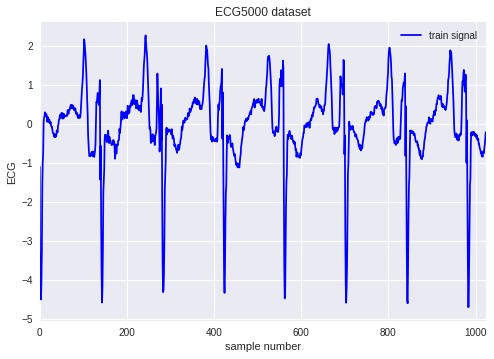

In [3]:
#visualize data
X_vis = np.squeeze(X_train.reshape(1, X_train.size))
plt.figure()
plt.plot(range(1024), X_vis[:1024], color='blue', label='train signal')
plt.title('ECG5000 dataset')
plt.xlabel('sample number')
plt.ylabel('ECG')
plt.legend()
plt.xlim([0, 1024])
plt.show()

Due to the regularity in our data, we are going to use stateful LSTMs, which means that latent states for the sample of each batch will be used as initial states for the samples in the next batch. For stateful LSTMs, we need to make sure that the number of training examples is evenly divisible into the number of batches. In addition, we will reshape our data into the input shape expected by LSTM: (batch_size, time_steps, data_dimension) and convert our class label using one-hot encoding.

In [4]:
#prepare data
batch_size = 32
num_epochs = 128

#scaler = MinMaxScaler(feature_range=(-1, 1))
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

num_classes = len(set(y_train).union(set(y_test)))
y_train = to_categorical(y_train-1, num_classes=num_classes) 
y_test = to_categorical(y_test-1, num_classes=num_classes)

#for stateful LSTMs, need fixed size batches
num_batches_train = np.int(X_train.shape[0]/batch_size)
X_train = X_train[0:num_batches_train*batch_size,:,:]
y_train = y_train[0:num_batches_train*batch_size]

num_batches_test = np.int(X_test.shape[0]/batch_size)
X_test = X_test[0:num_batches_test*batch_size,:,:]
y_test = y_test[0:num_batches_test*batch_size]

We'll use a three-layer stacked LSTM with 64 cells and Adam optimizer with initial learning rate of 0.001

In [5]:
#define the model 
#input shape: (batch_size, time_steps, data_dimension)

model = Sequential()
model.add(LSTM(64, return_sequences=True, stateful=True, 
               batch_input_shape=(batch_size, 1, X_train.shape[-1])))
model.add(LSTM(64, return_sequences=True, stateful=True))
model.add(LSTM(64, stateful=True))
model.add(Dense(num_classes, activation='softmax'))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

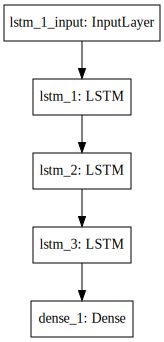

In [6]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

We are going to define a number of callbacks to monitor quantities of interest during training. In particular, we'll define a checkpoint to save model weights upon loss improvement, we will also monitor our training loss using tensorboard. We'll reduce our learning rate by a factor of 10 once we hit a plateau in our loss and we'll use early stopping to limit the number of training epochs in case there's no improvement in the loss.

In [7]:
#define callbacks
file_name = DATA_PATH + 'weights-checkpoint.hdf5'
checkpoint = ModelCheckpoint(file_name, monitor='loss', verbose=1, save_best_only=True, mode='min')
tensor_board = TensorBoard(log_dir='./logs', write_graph=False, write_images=False)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=8, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='loss', min_delta=0.01, patience=16, verbose=1)
callbacks_list = [checkpoint, tensor_board, reduce_lr, early_stopping]

In [8]:
#model training
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,
                 shuffle=False, callbacks=callbacks_list, verbose=1)

model.save(DATA_PATH + 'final_model.h5', overwrite=True)
model.save_weights(DATA_PATH + 'final_weights.h5',overwrite=True)


Epoch 1/128
480/480 [==============================] - 0s - loss: 1.5331 - acc: 0.5250     
Epoch 2/128
480/480 [==============================] - 0s - loss: 0.8373 - acc: 0.6062     
Epoch 3/128
480/480 [==============================] - 0s - loss: 0.8382 - acc: 0.6021     
Epoch 4/128
480/480 [==============================] - 0s - loss: 0.8232 - acc: 0.5667     
Epoch 5/128
480/480 [==============================] - 0s - loss: 0.7575 - acc: 0.6083     
Epoch 6/128
480/480 [==============================] - 0s - loss: 0.6948 - acc: 0.6729     
Epoch 7/128
480/480 [==============================] - 0s - loss: 0.6539 - acc: 0.6729     
Epoch 8/128
480/480 [==============================] - 0s - loss: 0.5932 - acc: 0.7312     
Epoch 9/128
480/480 [==============================] - 0s - loss: 0.5132 - acc: 0.7771     
Epoch 10/128
480/480 [==============================] - 0s - loss: 0.4397 - acc: 0.8354     
Epoch 11/128
480/480 [==============================] - 0s - loss: 0.3782 - acc

480/480 [==============================] - 0s - loss: 0.0936 - acc: 0.9750     
Epoch 27/128
480/480 [==============================] - 0s - loss: 0.0908 - acc: 0.9750     
Epoch 28/128
480/480 [==============================] - 0s - loss: 0.0866 - acc: 0.9750     
Epoch 29/128
480/480 [==============================] - 0s - loss: 0.0837 - acc: 0.9750     
Epoch 30/128
480/480 [==============================] - 0s - loss: 0.0813 - acc: 0.9708     
Epoch 31/128
480/480 [==============================] - 0s - loss: 0.0842 - acc: 0.9750     
Epoch 32/128
480/480 [==============================] - 0s - loss: 0.0799 - acc: 0.9792     
Epoch 33/128
480/480 [==============================] - 0s - loss: 0.0753 - acc: 0.9750     
Epoch 34/128
480/480 [==============================] - 0s - loss: 0.0744 - acc: 0.9750     
Epoch 35/128
480/480 [==============================] - 0s - loss: 0.0694 - acc: 0.9750     
Epoch 36/128
480/480 [==============================] - 0s - loss: 0.0660 - acc: 0.

480/480 [==============================] - 0s - loss: 0.0390 - acc: 0.9958     
Epoch 57/128
480/480 [==============================] - 0s - loss: 0.0397 - acc: 0.9938     
Epoch 58/128
480/480 [==============================] - 0s - loss: 0.0356 - acc: 0.9938     
Epoch 59/128
480/480 [==============================] - 0s - loss: 0.0340 - acc: 0.9938     
Epoch 60/128
480/480 [==============================] - 0s - loss: 0.0317 - acc: 0.9938     
Epoch 61/128
480/480 [==============================] - 0s - loss: 0.0301 - acc: 0.9938     
Epoch 62/128
480/480 [==============================] - 0s - loss: 0.0299 - acc: 0.9938     
Epoch 63/128
480/480 [==============================] - 0s - loss: 0.0281 - acc: 0.9958     
Epoch 64/128
480/480 [==============================] - 0s - loss: 0.0284 - acc: 0.9938     
Epoch 65/128
480/480 [==============================] - 0s - loss: 0.0239 - acc: 0.9958     
Epoch 66/128
480/480 [==============================] - 0s - loss: 0.0264 - acc: 0.

Let's evaluate our model on the test set:

In [9]:
#model evaluation
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print "\ntest loss: ", test_loss
print "test accuracy: ", test_acc

4448/4480 [============================>.] - ETA: 0s
test loss:  0.729023564387
test accuracy:  0.74375


We achieved an accuracy of 74% on the test set!

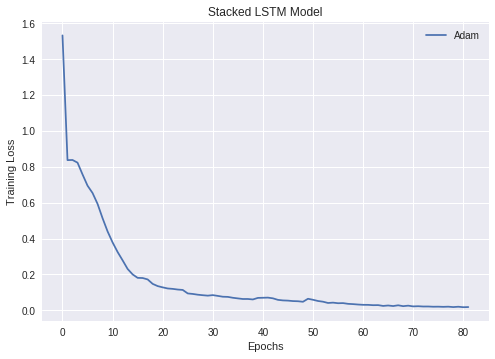

In [10]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], label='Adam')
plt.title('Stacked LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.savefig('./figures/stacked_lstm_training_loss.png')
plt.show()

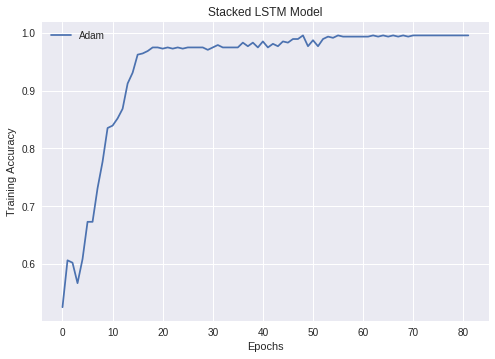

In [11]:
plt.figure()
plt.plot(hist.history['acc'], label='Adam')
plt.title('Stacked LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.savefig('./figures/stacked_lstm_training_acc.png')
plt.show()

In [12]:
plot_model(model, to_file='./figures/stacked_lstm_model.png')

From the loss and accuracy plots we can see that early stopping limited the number of epochs to 80 which is when our objective stopped improving. In addition, we can use tensorboard to visualize our training loss and accuracy plots by executing "tensorboard --logdir=./logs/" in the terminal.